In [1]:
from mss import mss    # mss used for screen capture
import pydirectinput   # sending commands
import cv2             # open cv for frame processing
import numpy as np 
import pytesseract     # FOR OPTICAL CHARACTER RECOGNITION
from matplotlib import pyplot as plt
import time 
from gymnasium import spaces
from gymnasium import Env
from PIL import Image
from gym.spaces import Box, Discrete
import cv2
import numpy as np

In [ ]:
def preprocessing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Increase contrast and sharpness
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
            sharpened, 255, 
            cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY_INV, 
            15, 8
        )

    # Morphological operations
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded


def detect_objects(image):
    #print(image.shape)
    # Assuming the image shape is (height, width, 100)
    #image = image[:, :, :3]  # Take the first three channels
    # Select first three channels assuming image is in CHW format:
    image = image[:3, :, :]
    # Transpose to HWC format:
    image = np.transpose(image, (1, 2, 0))


    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #print(hsv)
    # Define HSV color ranges for different objects
    cash_lower = np.array([50, 100, 100])    # Green (Cash)
    cash_upper = np.array([90, 255, 255]) 

    police_lower = np.array([0, 0, 0])       # Black (Police Cars)
    police_upper = np.array([180, 255, 50]) 

    player_lower = np.array([0, 150, 100])   # Red (Player Car)
    player_upper = np.array([10, 255, 255])  

    stone_lower = np.array([15, 20, 150])    # Light brown/beige
    stone_upper = np.array([35, 100, 255]) 

    # Create masks
    cash_mask = cv2.inRange(hsv, cash_lower, cash_upper)
    police_mask = cv2.inRange(hsv, police_lower, police_upper)
    player_mask = cv2.inRange(hsv, player_lower, player_upper)
    stone_mask = cv2.inRange(hsv, stone_lower, stone_upper)
    #print(police_mask)
    
    # Count pixels
    cash_pixels = np.sum(cash_mask > 0)
    police_pixels = np.sum(police_mask > 0)
    player_pixels = np.sum(player_mask > 0)
    stone_pixels = np.sum(stone_mask > 0)

    return cash_pixels, police_pixels, stone_pixels

def press(delay, key):
    pydirectinput.keyDown(key)
    time.sleep(delay)
    pydirectinput.keyUp(key)
    
class WebGame(Env):
    def __init__(self):      # Setting up the environment and observation spaces
        super().__init__()   # for using the base class of gym
        #self.observation_space = spaces.Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.observation_space = spaces.Box(low=0, high=255, shape=(3, 83, 100), dtype=np.uint8)
        self.action_space = spaces.Discrete(9)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 230, 'left': 630, 'width': 690, 'height':740}
        self.done_location = {'top':440, 'left': 550, 'width': 380, 'height':90}

    def step(self, action):
        action_map = { 
            0:'left1',
            1: 'left2', 
            2: 'left3',
            3: 'left4',
            4: 'right1',
            5:'right2',
            6:'right3',
            7:'right4',
            8:'no_op'
        }
        if action != 8:
            if action == 0:
                press(0.1, 'left')  # left1
            elif action == 1:
                press(0.2, 'left')  # left2
            elif action == 2:
                press(0.3, 'left')  # left3
            elif action == 3:
                press(0.5, 'left')  # left4
            elif action == 4:
                press(0.1, 'right')  # right1
            elif action == 5:
                press(0.2, 'right')  # right2
            elif action == 6:
                press(0.3, 'right')  # right3
            else:
                press(0.5, 'right')  # right4

        done, done_cap = self.get_done()   
        observation = self.get_observation()

        # Detect objects
        cash_pixels, police_pixels, stone_pixels = detect_objects(observation)

        # Define new reward function
        reward = 2
        if cash_pixels > 5:  # If cash is detected
            reward += 5
        if police_pixels > 20:  # If police car is detected
            reward -= 10
        if stone_pixels > 30:  # If stone is detected
            reward -= 100

        truncated = False
        info = {}
        return observation, reward, done,truncated, info
        
    def reset(self,seed=None,options=None):
        time.sleep(1)
        pydirectinput.click(x=960, y=540)
        pydirectinput.press('space')
        pydirectinput.press('space')
        return self.get_observation(),{}
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self): 
        cv2.destroyAllWindows()
    
    # def get_observation(self):       # processing info from the frames 
    #     raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
    #     gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    #     resized = cv2.resize(gray, (100,83))
    #     channel = np.reshape(resized, (1,83,100))
    #     return channel
    
    def get_observation(self):       
        raw = np.array(self.cap.grab(self.game_location))  # Capture screen
        raw = cv2.cvtColor(raw, cv2.COLOR_BGRA2BGR)  # Convert from BGRA to BGR

        # Resize to (100, 83) with high-quality interpolation
        resized = cv2.resize(raw, (100, 83), interpolation=cv2.INTER_CUBIC)

        # Transpose to (Channels, Height, Width)
        return np.transpose(resized, (2, 0, 1))  # (3, 83, 100)
    
    def get_reward_observation(self):       
        raw = np.array(self.cap.grab(self.game_location))  # Capture screen
        raw = cv2.cvtColor(raw, cv2.COLOR_BGRA2BGR)  # Convert from BGRA to BGR

        # Resize to (100, 83) with high-quality interpolation
        resized = cv2.resize(raw, (70, 50), interpolation=cv2.INTER_CUBIC)

        # Transpose to (Channels, Height, Width)
        return np.transpose(resized, (2, 0, 1))  # (3, 83, 100)
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location)).astype(np.uint8)
        plt.imshow(self.cap.grab(self.done_location))

        done_cap=preprocessing(done_cap)

        done_strings = ['HIGH']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        custom_config = r'--oem 3 --psm 6'
        res = pytesseract.image_to_string(done_cap, config=custom_config)[:4]
        
        # print(res)
        if res in done_strings:
            done = True
        return done, done_cap

In [10]:
env = WebGame()

In [11]:
obs=env.get_observation()

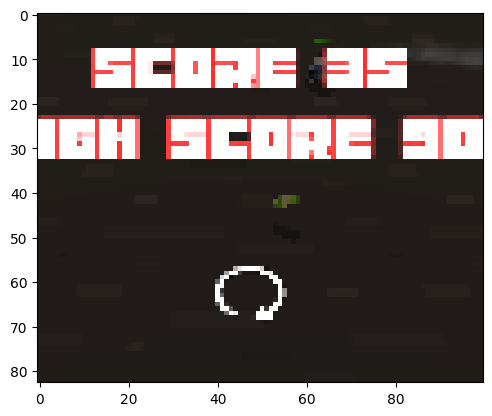

In [12]:
# plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))
plt.imshow(cv2.cvtColor(obs.transpose(1, 2, 0), cv2.COLOR_BGR2RGB))

True

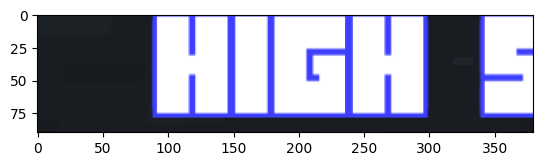

In [13]:
done, done_cap = env.get_done()
done

In [7]:
pytesseract.image_to_string(done_cap)

''

Total Reward for episode 0 is -22


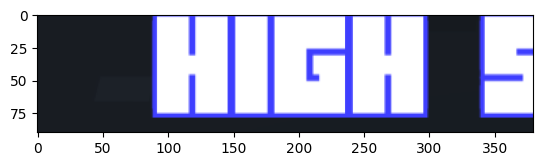

In [14]:
for episode in range(1): 
    obs = env.reset()
    done = False  
    total_reward = 0
    while not done: 
        obs, reward, done,_,info =  env.step(env.action_space.sample())
        total_reward  += reward    
    print('Total Reward for episode {} is {}'.format(episode, total_reward))       

In [63]:
import os     
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

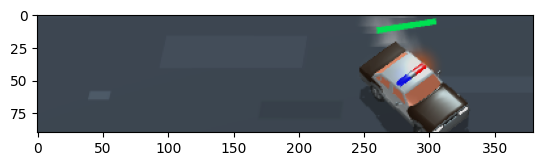

In [9]:
env_checker.check_env(env)  

In [64]:
from stable_baselines3.common.callbacks import BaseCallback
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:  
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [65]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

env = WebGame()
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000)  # Reduced by 10xlearning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\hp\anaconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.98GB > 1.24GB
  warnings.warn(


Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 77.8     |
|    ep_rew_mean      | 77.8     |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 358      |
|    total_timesteps  | 311      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00315  |
|    n_updates        | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 79.6     |
|    ep_rew_mean      | 79.6     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 740      |
|    total_timesteps  | 637      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.29e-0

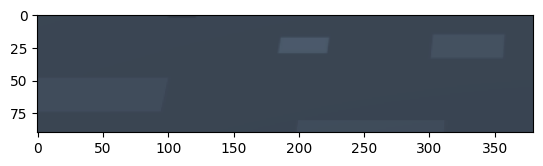

In [13]:
model.learn(total_timesteps=18000, callback=callback)

In [ ]:
model.load('train/best_model18000')

c:\Users\hp\anaconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.99GB > 1.06GB
  warnings.warn(


Total Reward for episode 0 is 163
Total Reward for episode 1 is 20


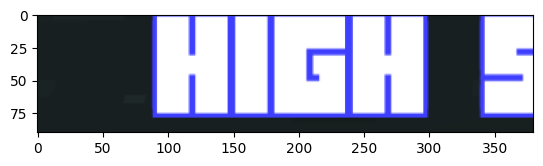

In [14]:
for episode in range(2): 
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action,_ = model.predict(obs)
        obs, reward, done,_,info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)